In [1]:
import datetime
import time
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from functools import reduce
from tqdm.notebook import tqdm
import warnings
import json
import re
import math
# 模型训练及测试
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import pydotplus
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import joblib
from IPython.display import Image

# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, NearMiss
# from imblearn.combine import SMOTEENN, SMOTETomek

# 画图
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['font.family']='sans-serif'

from dtreeviz.trees import dtreeviz, explain_prediction_path

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 5000)

In [2]:
def get_bin(sample_df_raw, column):
    b = sorted(set([-np.inf
#                     , np.quantile(sample_df_raw[column], 0.1)
                    , np.quantile(sample_df_raw[column], 0.2)
#                     , np.quantile(sample_df_raw[column], 0.3)
                    , np.quantile(sample_df_raw[column], 0.4)
#                     , np.quantile(sample_df_raw[column], 0.5)
                    , np.quantile(sample_df_raw[column], 0.6)
#                     , np.quantile(sample_df_raw[column], 0.7)
                    , np.quantile(sample_df_raw[column], 0.8)
#                     , np.quantile(sample_df_raw[column], 0.9)
                    , np.inf]))
    return pd.cut(sample_df_raw[column], b)


def get_metrics(sample_df, column, y, psi_split):
    tmp_df = sample_df[['order_time', column, y]].copy(deep=True)
    tmp_df = tmp_df[tmp_df[column]!=-9999].reset_index(drop=True)
    
    total = tmp_df.shape[0]
    bad = tmp_df[tmp_df[y]==1].shape[0]
    good = tmp_df[tmp_df[y]==0].shape[0]
    badratio = bad/total
    
    
    tmp_df[column+'_bin'] = get_bin(sample_df, column)
    column_df = tmp_df.groupby(column+'_bin')[y].agg([np.size, np.sum]).reset_index().dropna(axis=0, how='any')
    column_df.columns = ['分箱', '个数', '坏样本']
    column_df['特征'] = column
    column_df['整体个数'] = total
    column_df['整体坏样本'] = bad
    column_df['整体好样本'] = good
    column_df['整体badratio'] = badratio
    column_df['好样本'] = column_df['个数'] - column_df['坏样本']
    column_df['badratio'] = column_df['坏样本']/column_df['个数']
    column_df['累计badrate'] = column_df['坏样本'].cumsum()/bad
    column_df['累计goodrate'] = column_df['好样本'].cumsum()/good
    column_df['KS分量'] = abs(column_df['累计badrate'] - column_df['累计goodrate'])
    column_df['KS'] = max(column_df['KS分量'])
    column_df['WOE'] = np.log((column_df['好样本']/good)/(column_df['坏样本']/bad))
    column_df['IV'] = sum((column_df['好样本']/good - column_df['坏样本']/bad)*column_df['WOE'])
    column_df['lift'] = column_df['badratio']/badratio
#     column_df['minlift'] = min(column_df['lift'])
#     column_df['maxlift'] = max(column_df['lift'])
#     column_df['上累计lift'] = (column_df['坏样本'].cumsum()/column_df['个数'].cumsum())/badratio
#     column_df['下累计lift'] = ((bad-column_df['坏样本'].cumsum())/(total-column_df['个数'].cumsum()))/badratio
#     column_df['max上累计lift'] = max(column_df['上累计lift'])
#     column_df['max下累计lift'] = max(column_df['下累计lift'])
    
    Actual = tmp_df[tmp_df['order_time']>psi_split]
    Expect = tmp_df[tmp_df['order_time']<=psi_split]
    ashape = Actual.shape[0]
    eshape = Expect.shape[0]
    apsi_df = Actual.groupby(column+'_bin')[y].agg(np.size).reset_index()
    epsi_df = Expect.groupby(column+'_bin')[y].agg(np.size).reset_index()
    apsi_df.columns = ['分箱', 'a个数']
    epsi_df.columns = ['分箱', 'e个数']
    apsi_df['a占比'] = apsi_df['a个数']/ashape
    epsi_df['e占比'] = epsi_df['e个数']/eshape
    apsi_df['a占比'] = apsi_df['a占比'].fillna(0)
    epsi_df['e占比'] = epsi_df['e占比'].fillna(0)
    psi_df = apsi_df.merge(epsi_df, on='分箱', how='left')
    psi_df['PSI分量'] = (psi_df['a占比']-psi_df['e占比'])*np.log(psi_df['a占比']/psi_df['e占比'])
    psi_df['PSI分量'] = psi_df['PSI分量'].replace(np.inf, 0)
    column_df = column_df.merge(psi_df, on='分箱', how='left')
    column_df['PSI'] = sum(column_df['PSI分量'])
    

#     floor = np.quantile(tmp_df[column], 0.05)
#     roof = np.quantile(tmp_df[column], 0.95)
#     tmp_cut = set(tmp_df[(tmp_df[column]>=floor)&(tmp_df[column]<=roof)][column])

#     # bestlift
#     maxlift = 0
#     minlift = 1
#     maxliftcut = floor
#     minliftcut = floor

#     for c in tmp_cut:
#         tmp_df[column+'_bin2'] = pd.cut(tmp_df[column], [-np.inf, c, np.inf])
#         tmp_column_df = tmp_df.groupby(column+'_bin2')[y].agg([np.size, np.sum]).reset_index().dropna(axis=0, how='any')
#         tmp_column_df.columns = ['分箱', '个数', '坏样本']
#         tmp_column_df['特征'] = column
#         tmp_column_df['badratio'] = tmp_column_df['坏样本']/tmp_column_df['个数']
#         tmpmaxlift = max(tmp_column_df['badratio'])/badratio
#         tmpminlift = min(tmp_column_df['badratio'])/badratio
        
#         if maxlift < tmpmaxlift:
#             maxlift = tmpmaxlift
#             maxliftcut = c
#         if minlift > tmpminlift:
#             minlift = tmpminlift
#             minliftcut = c
            
#     column_df['maxlift'] = maxlift
#     column_df['minlift'] = minlift
#     column_df['maxliftcut'] = maxliftcut
#     column_df['minliftcut'] = minliftcut
    
#     # bestks
#     bestks = 0
#     bestkscut = floor

#     for c in tmp_cut:
#         bad_sample = sum(tmp_df[tmp_df[column]<=c][y])
#         good_sample = tmp_df[tmp_df[column]<=c][y].shape[0] - bad_sample
#         tmpbestks = abs(bad_sample/bad - good_sample/good)
        
#         if bestks < tmpbestks:
#             bestks = tmpbestks
#             bestkscut = c
            
#     column_df['bestks'] = bestks
#     column_df['bestkscut'] = bestkscut
    
    return column_df[[
        '特征'
        ,'分箱'
        ,'整体个数'
        ,'整体坏样本'
        ,'整体好样本'
        ,'整体badratio'
        ,'个数'
        ,'坏样本'
        ,'好样本'
        ,'badratio'
        ,'累计badrate'
        ,'累计goodrate'
        ,'KS分量'
        ,'KS'
        ,'WOE'
        ,'IV'
        ,'lift'
#         ,'minlift'
#         ,'maxlift'
#         ,'minliftcut'
#         ,'maxliftcut'
#         ,'bestks'
#         ,'bestkscut'
#         ,'上累计lift'
#         ,'下累计lift'
#         ,'max上累计lift'
#         ,'max下累计lift'
        ,'a占比'
        ,'e占比'
        ,'PSI分量'
        ,'PSI'
]]


def get_ks(df):
    tmp_df = df.copy(deep=True)
    
    total = tmp_df.shape[0]
    bad = tmp_df[tmp_df['t']==1].shape[0]
    good = tmp_df[tmp_df['t']==0].shape[0]
    badratio = bad/total
    
    column_df = tmp_df.groupby('特征')['t'].agg([np.size, np.sum]).reset_index().dropna(axis=0, how='any')
    column_df.columns = ['分箱', '个数', '坏样本']
    column_df = column_df.sort_values(by='分箱', ascending=False).reset_index(drop=True)
    column_df['整体个数'] = total
    column_df['整体坏样本'] = bad
    column_df['整体好样本'] = good
    column_df['整体badratio'] = badratio
    column_df['好样本'] = column_df['个数'] - column_df['坏样本']
    column_df['badratio'] = column_df['坏样本']/column_df['个数']
    column_df['累计badrate'] = column_df['坏样本'].cumsum()/bad
    column_df['累计goodrate'] = column_df['好样本'].cumsum()/good
    column_df['KS分量'] = abs(column_df['累计badrate'] - column_df['累计goodrate'])
    column_df['KS'] = max(column_df['KS分量'])
    column_df['累计lift'] = (column_df['坏样本'].cumsum()/column_df['个数'].cumsum())/badratio
    
    return column_df[['分箱','个数','坏样本','好样本','累计badrate','累计goodrate','累计lift','KS分量','KS','badratio']]


def coverage_calc(df, colnames=None, mi_values=[], mi_dict={}, bar=False):
    result = []
    cnt = []
    if not colnames:
        colnames = df.columns.tolist()
    for name in colnames:
        mi_item_total = df[name].isnull().sum() + df[name].isin(mi_values).sum()
        mi_perc = mi_item_total / len(df[name])*100
        name_coverage = 100 - mi_perc
#         name_coverage = "%.2f%%" % name_coverage
        cnt.append(df.shape[0] - mi_item_total)
        result.append(name_coverage)

    if bar:
        return pd.DataFrame({"变量": colnames, "非空个数": cnt, "占比": result}).style.bar(subset=["占比"])
    else:
        return pd.DataFrame({"变量": colnames, "非空个数": cnt, "占比": result})


def datediff(t1, t2):
    try:
        _t1 = datetime.datetime.strptime(str(t1),"%Y-%m-%d %H:%M:%S")
        _t2 = datetime.datetime.strptime(str(t2),"%Y-%m-%d %H:%M:%S")
    except:
        return -9999
    return (_t1 - _t2).days


def concentration(df):
    tt = target.replace('_ind','')
    amo =np.sum(df[tt+'amo'])
    amosum = np.sum(df[tt+'amosum'])
    return amo/amosum

# 导入

In [3]:
# 导入数据
tmp_repayinfo_shl = pd.read_csv('./raw_data/tmp_repayinfo_shl_20221213.txt')

In [4]:
tmp_repayinfo_shl.shape

(174949, 101)

In [5]:
list(tmp_repayinfo_shl.columns)

['order_code',
 'isvirtuel',
 'paymtd',
 'audit',
 'order_time',
 'submit_time',
 'order_code_pre',
 'effect_time',
 'user_mobile',
 'user_type',
 'user_type2',
 'user_type3',
 'user_type_new',
 'ctggrade',
 'ctg_two_new',
 'category_one_name',
 'category_two_name',
 'art_name',
 'art_count',
 'new_decision_flow',
 'pay_method',
 'fd3_ind',
 'fd7_ind',
 'fd15_ind',
 'fd30_ind',
 'fpd3_ind',
 'fpd7_ind',
 'fpd15_ind',
 'fpd30_ind',
 'fpd3amo',
 'fpd7amo',
 'fpd15amo',
 'fpd30amo',
 'fpd3amosum',
 'fpd7amosum',
 'fpd15amosum',
 'fpd30amosum',
 'mob6_ind',
 'mob6_dpd30amo',
 'mob6_amosum',
 'stagin_count',
 'staging_amo',
 'channel_one',
 'channel_two',
 '性别',
 '年龄',
 '紧急联系人',
 '收货手机',
 '手机归属地省份',
 '手机归属地城市',
 '身份证归属地省份',
 '身份证归属地城市',
 '检测省份',
 '检测城市',
 '收货省份',
 '收货城市',
 '收货地址',
 '紧急联系人是否有效',
 '收货手机是否有效',
 '收货行为_检测城市和手机归属地城市不一致',
 '收货行为_检测城市和身份证归属地城市不一致',
 '收货行为_检测城市和收货城市不一致',
 '收货行为_手机归属地城市和身份证归属地城市不一致',
 '收货行为_手机归属地城市和收货城市不一致',
 '收货行为_身份证归属地城市和收货城市不一致',
 '收货行为_检测省份和手机归属地省份不一致',
 '收货行为_检

# 调整

In [6]:
# 缺失值与标签
repayinfo = tmp_repayinfo_shl.copy(deep=True)
repayinfo.replace('\\N', np.nan, inplace=True)
repayinfo.replace('N', np.nan, inplace=True)
repayinfo['fpd3amo'] = repayinfo['fpd3amo'].astype('float64')
repayinfo['fpd7amo'] = repayinfo['fpd7amo'].astype('float64')
repayinfo['fpd15amo'] = repayinfo['fpd15amo'].astype('float64')
repayinfo['fpd30amo'] = repayinfo['fpd30amo'].astype('float64')
# repayinfo['mob6_dpd30amo'] = repayinfo['mob6_dpd30amo'].astype('float64')
repayinfo['fpd3amosum'] = repayinfo['fpd3amosum'].astype('float64')
repayinfo['fpd7amosum'] = repayinfo['fpd7amosum'].astype('float64')
repayinfo['fpd15amosum'] = repayinfo['fpd15amosum'].astype('float64')
repayinfo['fpd30amosum'] = repayinfo['fpd30amosum'].astype('float64')
# repayinfo['mob6_dpd30amosum'] = repayinfo['mob6_amosum'].astype('float64')

In [7]:
# 逾期标签
repayinfo['fd3_ind'] = repayinfo['fd3_ind'].astype('float64')
repayinfo['fd7_ind'] = repayinfo['fd7_ind'].astype('float64')
repayinfo['fd15_ind'] = repayinfo['fd15_ind'].astype('float64')
repayinfo['fd30_ind'] = repayinfo['fd30_ind'].astype('float64')
# repayinfo['mob6_dd30_ind'] = repayinfo['mob6_ind'].astype('float64')
repayinfo['fpd3_ind'] = repayinfo['fpd3_ind'].astype('float64')
repayinfo['fpd7_ind'] = repayinfo['fpd7_ind'].astype('float64')
repayinfo['fpd15_ind'] = repayinfo['fpd15_ind'].astype('float64')
repayinfo['fpd30_ind'] = repayinfo['fpd30_ind'].astype('float64')
# repayinfo['mob6_dpd30_ind'] = repayinfo.mob6_dpd30amo.map(lambda x: 1 if x>0 else 0)

In [8]:
ftr_ord = [
#  '紧急联系人是否有效',
#  '收货手机是否有效',
#  '收货行为_检测城市和手机归属地城市不一致',
#  '收货行为_检测城市和身份证归属地城市不一致',
#  '收货行为_检测城市和收货城市不一致',
#  '收货行为_手机归属地城市和身份证归属地城市不一致',
#  '收货行为_手机归属地城市和收货城市不一致',
#  '收货行为_身份证归属地城市和收货城市不一致',
#  '收货行为_检测省份和手机归属地省份不一致',
#  '收货行为_检测省份和身份证归属地省份不一致',
#  '收货行为_检测省份和收货省份不一致',
#  '收货行为_手机归属地省份和身份证归属地省份不一致',
#  '收货行为_手机归属地省份和收货省份不一致',
#  '收货行为_身份证归属地省份和收货省份不一致',
#  '手机号码_注册手机和收货手机不一致',
#  '手机号码_收货手机和紧急联系人不一致',
]

ftr_num = [
 '上笔借款已还',
 '上笔高风险套现已还',
 '上笔易套现已还',
]

ftr_ctg =[
 '紧急联系人是否有效',
 '收货手机是否有效',
 '收货行为_检测城市和手机归属地城市不一致',
 '收货行为_检测城市和身份证归属地城市不一致',
 '收货行为_检测城市和收货城市不一致',
 '收货行为_手机归属地城市和身份证归属地城市不一致',
 '收货行为_手机归属地城市和收货城市不一致',
 '收货行为_身份证归属地城市和收货城市不一致',
 '收货行为_检测省份和手机归属地省份不一致',
 '收货行为_检测省份和身份证归属地省份不一致',
 '收货行为_检测省份和收货省份不一致',
 '收货行为_手机归属地省份和身份证归属地省份不一致',
 '收货行为_手机归属地省份和收货省份不一致',
 '收货行为_身份证归属地省份和收货省份不一致',
 '手机号码_注册手机和收货手机不一致',
 '手机号码_收货手机和紧急联系人不一致',
 '首笔产品',
 '3天内有无借款',
 '7天内有无借款',
 '30天内有无借款',
 '90天内有无借款',
 '3天内有无高风险或易套现',
 '7天内有无高风险或易套现',
 '30天内有无高风险或易套现',
 '90天内有无高风险或易套现',
 '3天内有无虚拟订单',
 '7天内有无虚拟订单',
 '30天内有无虚拟订单',
 '90天内有无虚拟订单',
 '3天内有无正常品类',
 '7天内有无正常品类',
 '30天内有无正常品类',
 '90天内有无正常品类',
]

In [9]:
# dummy
enc = OneHotEncoder()
category_df = enc.fit_transform(repayinfo[ftr_ctg]).toarray()

category_ftr = []
for i, vl in enumerate(enc.categories_):
    for v in vl:
        try:
            category_ftr.append(ftr_ctg[i]+'_'+str(v))
        except:
            category_ftr.append(ftr_ctg[i]+'_'+'空')
        
onehot_df = pd.DataFrame(category_df, columns=category_ftr)

In [10]:
repayinfo = repayinfo.join(onehot_df)
ftr_dummy = list(onehot_df.columns)

In [11]:
# 特征及target
target = 'fpd30_ind'
# target = 'mob6_dpd30_ind'
sample_valid = repayinfo[repayinfo[target.replace('p','')]==1].copy(deep=True)
sample_valid = sample_valid[sample_valid['user_type3'].isna()].reset_index(drop=True)

In [12]:
sample_valid.shape

(70996, 169)

In [13]:
# sample_valid.to_csv('./output/sample_高风险套现.csv', index=0)

# 分箱及指标

In [14]:
ftr_all = ftr_ord+ftr_num+ftr_dummy
ftr_all

['上笔借款已还',
 '上笔高风险套现已还',
 '上笔易套现已还',
 '紧急联系人是否有效_0',
 '紧急联系人是否有效_1',
 '收货手机是否有效_0',
 '收货手机是否有效_1',
 '收货行为_检测城市和手机归属地城市不一致_0',
 '收货行为_检测城市和手机归属地城市不一致_1',
 '收货行为_检测城市和身份证归属地城市不一致_0',
 '收货行为_检测城市和身份证归属地城市不一致_1',
 '收货行为_检测城市和收货城市不一致_0',
 '收货行为_检测城市和收货城市不一致_1',
 '收货行为_手机归属地城市和身份证归属地城市不一致_0',
 '收货行为_手机归属地城市和身份证归属地城市不一致_1',
 '收货行为_手机归属地城市和收货城市不一致_0',
 '收货行为_手机归属地城市和收货城市不一致_1',
 '收货行为_身份证归属地城市和收货城市不一致_0',
 '收货行为_身份证归属地城市和收货城市不一致_1',
 '收货行为_检测省份和手机归属地省份不一致_0',
 '收货行为_检测省份和手机归属地省份不一致_1',
 '收货行为_检测省份和身份证归属地省份不一致_0',
 '收货行为_检测省份和身份证归属地省份不一致_1',
 '收货行为_检测省份和收货省份不一致_0',
 '收货行为_检测省份和收货省份不一致_1',
 '收货行为_手机归属地省份和身份证归属地省份不一致_0',
 '收货行为_手机归属地省份和身份证归属地省份不一致_1',
 '收货行为_手机归属地省份和收货省份不一致_0',
 '收货行为_手机归属地省份和收货省份不一致_1',
 '收货行为_身份证归属地省份和收货省份不一致_0',
 '收货行为_身份证归属地省份和收货省份不一致_1',
 '手机号码_注册手机和收货手机不一致_0',
 '手机号码_注册手机和收货手机不一致_1',
 '手机号码_收货手机和紧急联系人不一致_0',
 '手机号码_收货手机和紧急联系人不一致_1',
 '首笔产品_其他',
 '首笔产品_首笔借款',
 '首笔产品_首笔虚拟',
 '首笔产品_首笔高风险或易套现',
 '3天内有无借款_无',
 '3天内有无借款_有',
 '7天内有无借款_无',
 '7天内有无借款_有',
 '30天内有无借款_无',
 '30天内有无借款_有'

In [15]:
# cov_df = coverage_calc(sample_valid, ftr_all, mi_values=[-9999])
# ftr_all = list(cov_df[cov_df['占比']>=60]['变量'])
# ftr_all = [x for x in ftr_all if not x.endswith('_空')]

In [16]:
bin_df = pd.DataFrame(columns=[])
for col in tqdm(ftr_all):    
    # 重要指标
    col_df = get_metrics(sample_valid, col, target, '2022-03-15')
    bin_df = bin_df.append(col_df, ignore_index=True)

  0%|          | 0/71 [00:00<?, ?it/s]

In [17]:
# bin_df[['特征','分箱','个数','KS','IV','minlift','maxlift','minliftcut','maxliftcut','bestks','bestkscut','a占比','e占比','PSI']].to_csv('./output/bin_df_d15.csv', index=0)

In [18]:
# bin_df = pd.read_csv('./output/bin_df_d15.csv')

# 特征选择

## 显著性特征

In [19]:
# sift_df = bin_df.groupby('特征')['KS','IV','minlift','maxlift','minliftcut','maxliftcut','bestks','bestkscut','PSI'].agg('max').reset_index()
sift_df = bin_df.groupby('特征')['KS','IV','lift','PSI'].agg('max').reset_index()

In [20]:
# sift_df.sort_values(by='maxlift', ascending=False)

sift_df.sort_values(by='KS', ascending=False)

# sift_df.sort_values(by='KS', ascending=False)

,特征,KS,IV,lift,PSI
4,30天内有无虚拟订单_无,0.129815,7.867860e-02,1.503522,0.024143
5,30天内有无虚拟订单_有,0.129815,7.867860e-02,1.503522,0.024143
29,90天内有无虚拟订单_有,0.125558,6.467352e-02,1.334563,0.009025
28,90天内有无虚拟订单_无,0.125558,6.467352e-02,1.334563,0.009025
21,7天内有无虚拟订单_有,0.101240,6.783266e-02,1.705863,0.009344
46,收货行为_手机归属地省份和收货省份不一致_1,0.092987,4.686642e-02,1.452689,0.000220
45,收货行为_手机归属地省份和收货省份不一致_0,0.092987,4.686642e-02,1.452689,0.000220
7,30天内有无高风险或易套现_有,0.087110,3.349445e-02,1.141150,0.000001
6,30天内有无高风险或易套现_无,0.087110,3.349445e-02,1.141150,0.000001
13,3天内有无虚拟订单_有,0.080714,5.508003e-02,1.779799,0.004565


In [21]:
# selection = lambda x: True if x['PSI']<0.1 and ((x['maxlift']>=1.5 or x['bestks']>=0.06) or (x['IV']>=0.1 and x['IV']!=np.inf)) else False
# select_list = sift_df[sift_df.apply(selection, axis=1)]['特征'].tolist()
# select_list
select_list = ftr_all

## 相关性

In [22]:
corr = sample_valid[ftr_all].corr()
# corr.to_csv('./output/corr_20220920.csv')

In [23]:
# 选相关性高的
while True:
    l = len(select_list)
    tmp_corr = sample_valid[select_list].corr()
    corr_matrix = np.array(tmp_corr)
    corr_pair_list = []
    for i in range(l):
        pair_list = []
        for j in range(l):
            if abs(corr_matrix[i][j])>=0.8:
                pair_list.append(select_list[j])
        corr_pair_list.append(pair_list)

    # 删除子集
    corr_pair_list_compressed = list(filter(lambda f: not any(set(f) < set(g) for g in corr_pair_list), corr_pair_list))

    # 筛指标最高的
    selected = set()
    for f in corr_pair_list_compressed:
    # for f in corr_pair_list:
        selected.add(sorted(f, key = lambda x: float(sift_df[sift_df['特征']==x]['KS']), reverse=True)[0])
#         selected.add(sorted(f, key = lambda x: ftr_importance[x], reverse=True)[0])

    if selected == set(select_list):
        break

    select_list = list(selected)

In [24]:
selected = sorted(select_list)
selected

['30天内有无借款_无',
 '30天内有无正常品类_有',
 '30天内有无虚拟订单_无',
 '30天内有无高风险或易套现_有',
 '3天内有无借款_无',
 '3天内有无正常品类_有',
 '7天内有无借款_无',
 '7天内有无虚拟订单_有',
 '7天内有无高风险或易套现_无',
 '90天内有无借款_无',
 '90天内有无正常品类_无',
 '90天内有无虚拟订单_有',
 '90天内有无高风险或易套现_无',
 '上笔借款已还',
 '上笔易套现已还',
 '上笔高风险套现已还',
 '手机号码_收货手机和紧急联系人不一致_0',
 '手机号码_注册手机和收货手机不一致_1',
 '收货手机是否有效_0',
 '收货行为_手机归属地城市和收货城市不一致_1',
 '收货行为_手机归属地城市和身份证归属地城市不一致_0',
 '收货行为_手机归属地省份和收货省份不一致_1',
 '收货行为_手机归属地省份和身份证归属地省份不一致_1',
 '收货行为_检测城市和手机归属地城市不一致_0',
 '收货行为_检测城市和收货城市不一致_1',
 '收货行为_检测城市和身份证归属地城市不一致_0',
 '收货行为_检测省份和手机归属地省份不一致_1',
 '收货行为_检测省份和收货省份不一致_1',
 '收货行为_检测省份和身份证归属地省份不一致_1',
 '收货行为_身份证归属地城市和收货城市不一致_1',
 '收货行为_身份证归属地省份和收货省份不一致_1',
 '紧急联系人是否有效_0',
 '首笔产品_其他',
 '首笔产品_首笔虚拟',
 '首笔产品_首笔高风险或易套现']

## 特征选择

In [25]:
sift_df[sift_df['特征'].isin(selected)].sort_values(by=['KS'], ascending=False)

,特征,KS,IV,lift,PSI
4,30天内有无虚拟订单_无,0.129815,7.867860e-02,1.503522,0.024143
29,90天内有无虚拟订单_有,0.125558,6.467352e-02,1.334563,0.009025
21,7天内有无虚拟订单_有,0.101240,6.783266e-02,1.705863,0.009344
46,收货行为_手机归属地省份和收货省份不一致_1,0.092987,4.686642e-02,1.452689,0.000220
7,30天内有无高风险或易套现_有,0.087110,3.349445e-02,1.141150,0.000001
22,7天内有无高风险或易套现_无,0.079432,2.543086e-02,1.184292,0.000041
62,收货行为_身份证归属地城市和收货城市不一致_1,0.076509,2.606990e-02,1.246676,0.000080
64,收货行为_身份证归属地省份和收货省份不一致_1,0.075309,3.484465e-02,1.434816,0.000238
58,收货行为_检测省份和收货省份不一致_1,0.067660,4.139705e-02,1.688089,0.000022
42,收货行为_手机归属地城市和收货城市不一致_1,0.064603,1.858772e-02,1.204859,0.000097


# 模型训练及测试

## 决策树

In [26]:
x = sample_valid[selected]
# x = selected_onehot_df
y = sample_valid[target]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.4,random_state = 0)

### 训练

In [27]:
sample_valid.shape

(70996, 169)

In [28]:
model = tree.DecisionTreeClassifier(max_depth=5
                                    ,min_samples_leaf=8000
                                    ,class_weight='balanced'
#                                     ,class_weight={0:1, 1:10}
                                    ,random_state=0)
clf = model.fit(x_train,y_train)
# 预测标签
y_pred_proba = clf.predict_proba(x_test)[:,1]
print("测试集的平均正确率：{}".format(clf.score(x_test,y_test)))

# # 计算回归值，取值小于0，表示p(y=1) <0.5,则该处标签属于1，否则属于0
# y_pred1 = clf.predict_proba(x_test)

测试集的平均正确率：0.5187858727419979


In [29]:
sorted(list(zip(selected, model.feature_importances_)), key=lambda x: x[1], reverse=True)

[('30天内有无虚拟订单_无', 0.8051139980449779),
 ('30天内有无高风险或易套现_有', 0.1291636180416078),
 ('90天内有无正常品类_无', 0.06572238391341434),
 ('30天内有无借款_无', 0.0),
 ('30天内有无正常品类_有', 0.0),
 ('3天内有无借款_无', 0.0),
 ('3天内有无正常品类_有', 0.0),
 ('7天内有无借款_无', 0.0),
 ('7天内有无虚拟订单_有', 0.0),
 ('7天内有无高风险或易套现_无', 0.0),
 ('90天内有无借款_无', 0.0),
 ('90天内有无虚拟订单_有', 0.0),
 ('90天内有无高风险或易套现_无', 0.0),
 ('上笔借款已还', 0.0),
 ('上笔易套现已还', 0.0),
 ('上笔高风险套现已还', 0.0),
 ('手机号码_收货手机和紧急联系人不一致_0', 0.0),
 ('手机号码_注册手机和收货手机不一致_1', 0.0),
 ('收货手机是否有效_0', 0.0),
 ('收货行为_手机归属地城市和收货城市不一致_1', 0.0),
 ('收货行为_手机归属地城市和身份证归属地城市不一致_0', 0.0),
 ('收货行为_手机归属地省份和收货省份不一致_1', 0.0),
 ('收货行为_手机归属地省份和身份证归属地省份不一致_1', 0.0),
 ('收货行为_检测城市和手机归属地城市不一致_0', 0.0),
 ('收货行为_检测城市和收货城市不一致_1', 0.0),
 ('收货行为_检测城市和身份证归属地城市不一致_0', 0.0),
 ('收货行为_检测省份和手机归属地省份不一致_1', 0.0),
 ('收货行为_检测省份和收货省份不一致_1', 0.0),
 ('收货行为_检测省份和身份证归属地省份不一致_1', 0.0),
 ('收货行为_身份证归属地城市和收货城市不一致_1', 0.0),
 ('收货行为_身份证归属地省份和收货省份不一致_1', 0.0),
 ('紧急联系人是否有效_0', 0.0),
 ('首笔产品_其他', 0.0),
 ('首笔产品_首笔虚拟', 0.0),
 ('首笔产品_首笔高风险或易套现', 0.0)]

### 验证

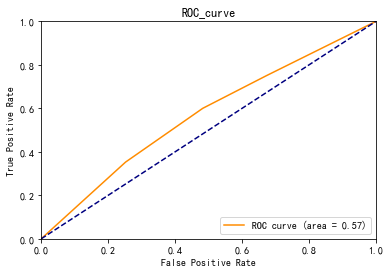

In [30]:
## 绘制ROC曲线并计算AUC的值
# fpr, tpr, threshold = roc_curve(y_train,clf.predict(x_train))
fpr, tpr, threshold = roc_curve(y_test,y_pred_proba)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")

In [31]:
threshold = []
recall,precision = [],[]
for t in np.arange(0.5,min(0.7,max(y_pred_proba)-0.001),0.01):
    y_pred = np.array([1 if x>=t else 0 for x in y_pred_proba])
    recall.append(len([y1 for y1,y2 in zip(y_test, y_pred) if y1==1 and y2==1])/len([x for x in y_test if x==1]))
    precision.append(len([y1 for y1,y2 in zip(y_test, y_pred) if y1==1 and y2==1])/len([x for x in y_pred if x==1]))
    threshold.append(t)

Text(0.51, 0.4529411764705883, 'threshold=0.51\nrecall=0.35\nprecision=0.02')

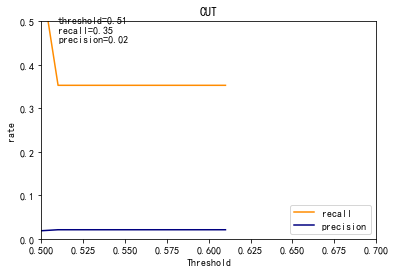

In [32]:
plt.plot(threshold, recall, color='darkorange', label='recall')
plt.plot(threshold, precision, color='navy', label='precision')
diff = list(abs(np.array(recall)-np.array(precision)))
best_threshold_3 = threshold[diff.index(min(diff))]
best_recall = recall[diff.index(min(diff))]
best_precision = precision[diff.index(min(diff))]
text = 'threshold='+str(round(best_threshold_3,2))+'\nrecall='+str(round(best_recall,2))+'\nprecision='+str(round(best_precision,2))
plt.xlim([0.5, 0.7])
plt.ylim([0.0, 0.5])
plt.xlabel('Threshold')
plt.ylabel('rate')
plt.title('CUT')
plt.legend(loc="lower right")
plt.annotate(text, xy=(best_threshold_3, best_recall), xytext=(best_threshold_3, best_recall+0.1))

### 逾期率

In [33]:
sample_valid_predict = sample_valid.copy(deep=True)
sample_valid_predict['predict'] = [1 if x>=best_threshold_3 else 0 for x in clf.predict_proba(sample_valid[selected])[:,1]]
# sample_valid_predict['predict'] = [1 if x>=best_threshold_3 else 0 for x in clf.predict_proba(selected_onehot_df)[:,1]]

In [34]:
concentration(sample_valid)

0.015027523169738481

In [35]:
sample_valid_predict.groupby('predict').apply(concentration)

predict
0    0.013015
1    0.022828
dtype: float64

In [36]:
Counter(sample_valid_predict['predict'])

Counter({0: 52965, 1: 18031})

### 画图


(dot.exe:8480): Pango-WARNING **: couldn't load font "MicrosoftYaHei Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.



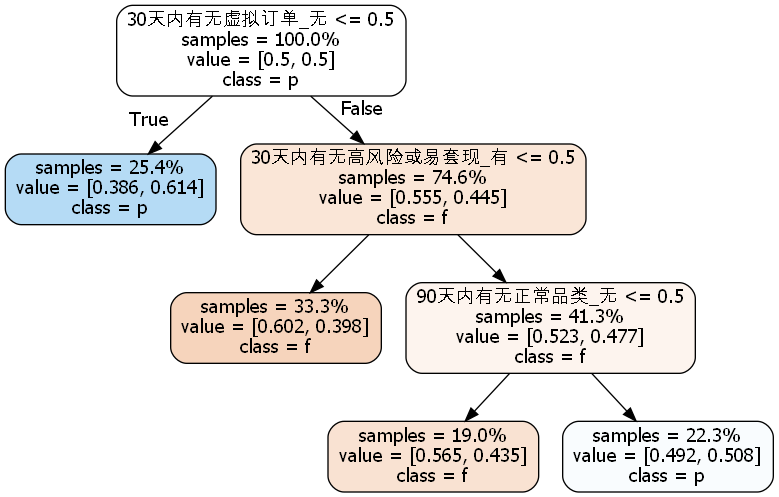

In [37]:
import os
os.environ["PATH"] += 'C:\\Users\\xx\\AppData\\Local\\Programs\\Python\\Python38\\Graphviz\\bin\\' + os.pathsep

dot_data = tree.export_graphviz(clf, # 注意这个参数为决策树对象名称
                                out_file=None,
                                feature_names=selected, # 还需要指定特征名
                                class_names=target,
                                filled=True,
                                impurity=False,
                                rounded=True,
                                proportion=True,
#                                 rotate=True
                               )

graph = pydotplus.graph_from_dot_data(dot_data.replace('helvetica', 'MicrosoftYaHei'))
# graph.get_nodes()[7].set_fillcolor("#FFF2DD")
Image(graph.create_png())

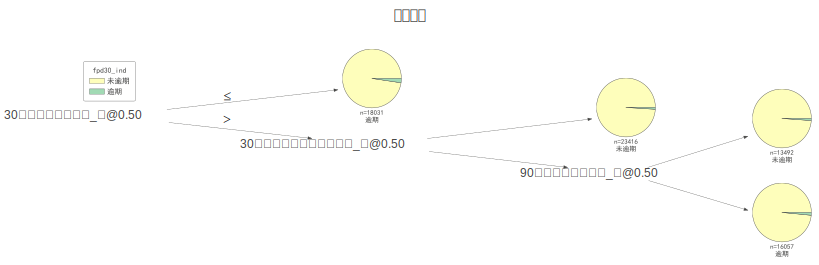

In [38]:
viz = dtreeviz(clf, 
               x_data=x,
               y_data=y,
               target_name=target,
               feature_names=selected,
#                feature_names=selected_category_ftr,
               class_names={0:'未逾期',1:'逾期'}, 
               title="人群分层",
               orientation='LR',
               fontname='SimHei',
               fancy=False,
#                X=x_test.loc[32598]
              )
viz

# 模型保存

In [39]:
# joblib.dump(clf2, './output/rf_20220802.model')